In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.svm import SVC
%matplotlib inline

**Data loading**

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_disease_data = heart_disease.data.features 
target = heart_disease.data.targets 
print(heart_disease_data, target)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

In [3]:
def map_target_values(value):
    if value > 0:
        return 1
    else:
        return 0

# Apply the function to the target column
target = target['num'].map(map_target_values)
target = target.rename('illness')
target.to_csv('target.csv')
print(target)

0      0
1      1
2      1
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    0
Name: illness, Length: 303, dtype: int64


In [4]:
target.value_counts()

illness
0    164
1    139
Name: count, dtype: int64

In [5]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [6]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


**Data formatting and cleaning**

*Renaming the columns with more meaningful names*

In [7]:
# Define a dictionary for renaming the columns
renaming_dict = {
    'age': 'age',
    'sex': 'gender',
    'cp': 'chest_pain_type',
    'trestbps': 'resting_blood_pressure',
    'chol': 'serum_cholesterol_mg_per_dl',
    'fbs': 'fasting_blood_sugar_gt_120_mg_per_dl',
    'restecg': 'resting_ecg_results',
    'thalach': 'maximum_heart_rate_achieved',
    'exang': 'exercise_induced_angina',
    'oldpeak': 'st_depression_induced_by_exercise_relative_to_rest',
    'slope': 'slope_of_peak_exercise_st_segment',
    'ca': 'number_of_major_vessels_colored_by_flourosopy',
    'thal': 'thalassemia',
}

# Code to rename the columns
heart_disease_data_renamed = heart_disease_data.rename(columns=renaming_dict)

*Checking for missing values*

In [8]:
heart_disease_data_renamed.isnull().sum()

age                                                   0
gender                                                0
chest_pain_type                                       0
resting_blood_pressure                                0
serum_cholesterol_mg_per_dl                           0
fasting_blood_sugar_gt_120_mg_per_dl                  0
resting_ecg_results                                   0
maximum_heart_rate_achieved                           0
exercise_induced_angina                               0
st_depression_induced_by_exercise_relative_to_rest    0
slope_of_peak_exercise_st_segment                     0
number_of_major_vessels_colored_by_flourosopy         4
thalassemia                                           2
dtype: int64

In [9]:
# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values using K-Nearest Neighbors
heart_disease_data_imputed = pd.DataFrame(imputer.fit_transform(heart_disease_data_renamed),                                      columns=heart_disease_data_renamed.columns)

# Check if there are any missing values left
missing_values_after_imputation = heart_disease_data_imputed.isnull().sum()

missing_values_after_imputation


age                                                   0
gender                                                0
chest_pain_type                                       0
resting_blood_pressure                                0
serum_cholesterol_mg_per_dl                           0
fasting_blood_sugar_gt_120_mg_per_dl                  0
resting_ecg_results                                   0
maximum_heart_rate_achieved                           0
exercise_induced_angina                               0
st_depression_induced_by_exercise_relative_to_rest    0
slope_of_peak_exercise_st_segment                     0
number_of_major_vessels_colored_by_flourosopy         0
thalassemia                                           0
dtype: int64

In [10]:
heart_disease_data_imputed.head(303)

,age,gender,chest_pain_type,resting_blood_pressure,serum_cholesterol_mg_per_dl,fasting_blood_sugar_gt_120_mg_per_dl,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise_relative_to_rest,slope_of_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,thalassemia
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0


## Preprocessing

In [11]:
# Identify categorical and numerical columns
numerical_cols = [
    'age', 
    'resting_blood_pressure', 
    'serum_cholesterol_mg_per_dl', 
    'maximum_heart_rate_achieved', 
    'st_depression_induced_by_exercise_relative_to_rest', 
    'number_of_major_vessels_colored_by_flourosopy'
]

categorical_cols = [
    'gender', 
    'chest_pain_type', 
    'fasting_blood_sugar_gt_120_mg_per_dl', 
    'resting_ecg_results', 
    'exercise_induced_angina', 
    'slope_of_peak_exercise_st_segment', 
    'thalassemia'
]

# Create a transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

# Apply transformations to the dataset
heart_disease_data_preprocessed = preprocessor.fit_transform(heart_disease_data_imputed)
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + onehot_feature_names.tolist()
heart_disease_data_preprocessed = pd.DataFrame(heart_disease_data_preprocessed, columns=feature_names)


## Data Visualization

In [12]:
heart_disease_data_preprocessed.head(303)

,age,resting_blood_pressure,serum_cholesterol_mg_per_dl,maximum_heart_rate_achieved,st_depression_induced_by_exercise_relative_to_rest,number_of_major_vessels_colored_by_flourosopy,gender_0.0,gender_1.0,chest_pain_type_1.0,chest_pain_type_2.0,...,exercise_induced_angina_0.0,exercise_induced_angina_1.0,slope_of_peak_exercise_st_segment_1.0,slope_of_peak_exercise_st_segment_2.0,slope_of_peak_exercise_st_segment_3.0,thalassemia_3.0,thalassemia_3.8,thalassemia_5.4,thalassemia_6.0,thalassemia_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,-0.721668,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,2.497157,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1.424215,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,-0.721668,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,-0.721668,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-1.046013,-1.234430,0.334813,-0.770990,0.138373,-0.721668,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
299,1.502821,0.700612,-1.038723,-0.376896,2.036303,1.424215,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
300,0.283813,-0.096170,-2.238149,-1.515388,0.138373,0.351273,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
301,0.283813,-0.096170,-0.206864,1.068113,-0.896862,0.351273,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


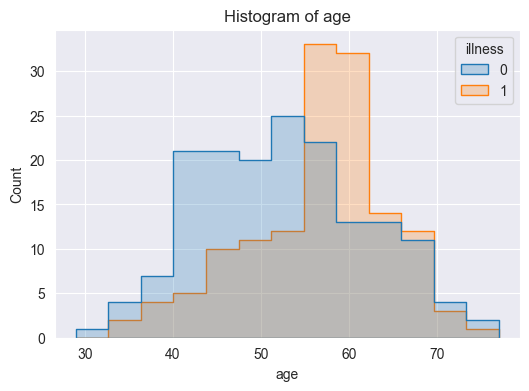

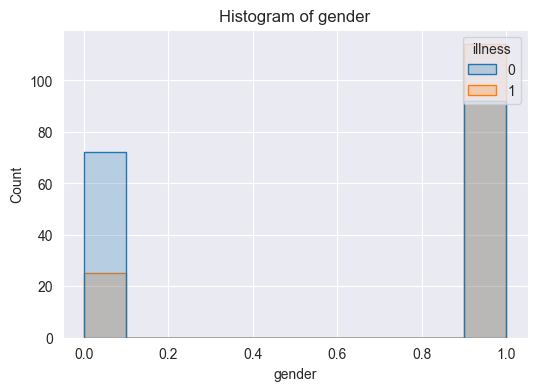

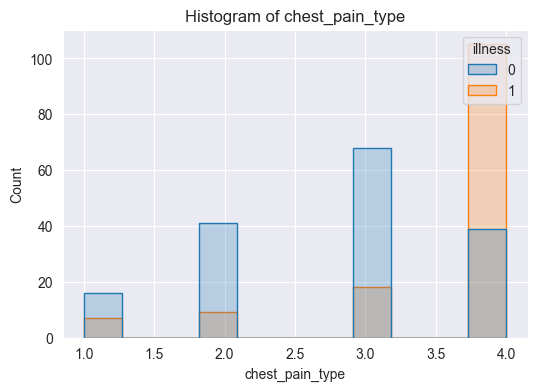

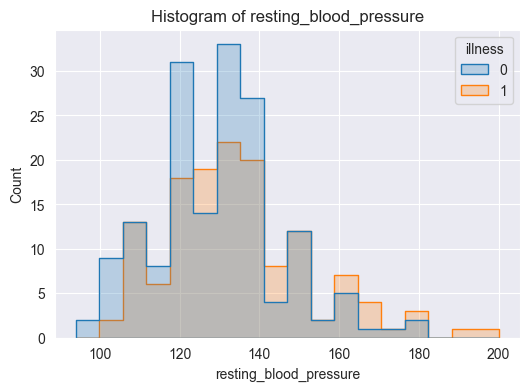

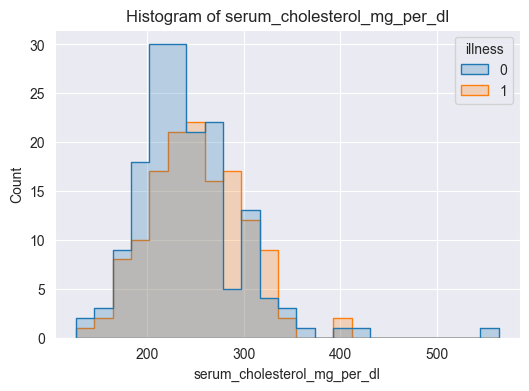

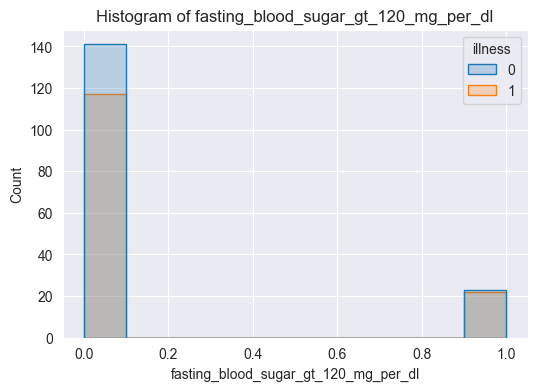

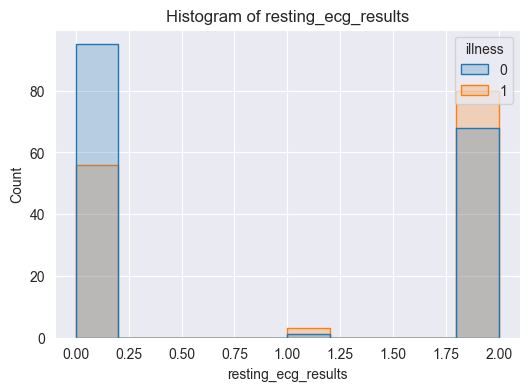

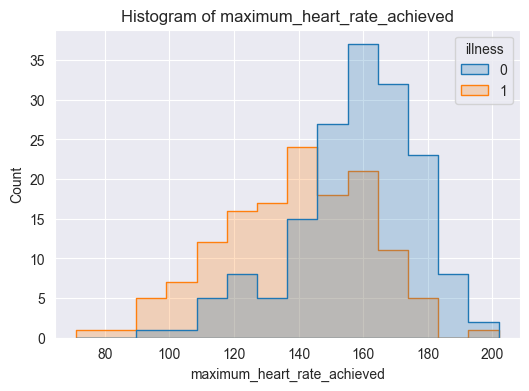

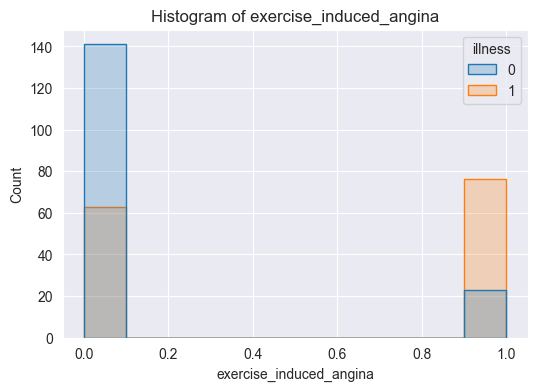

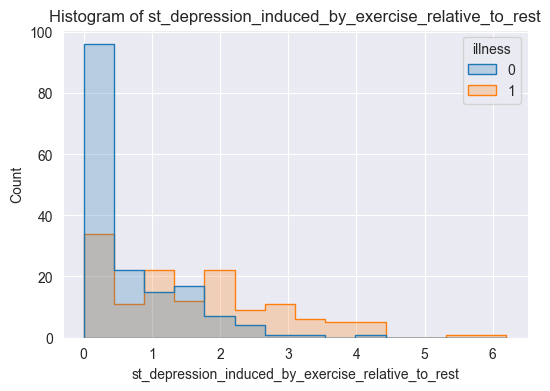

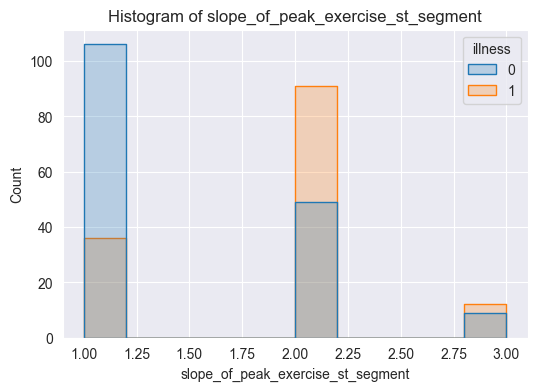

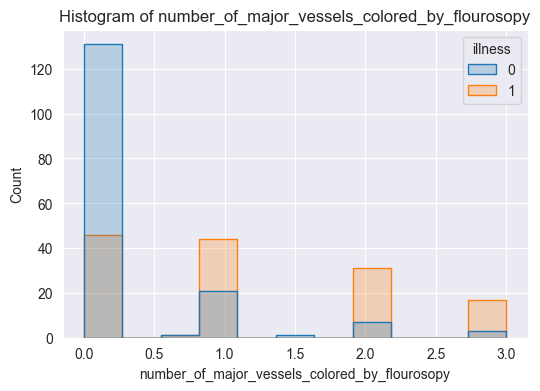

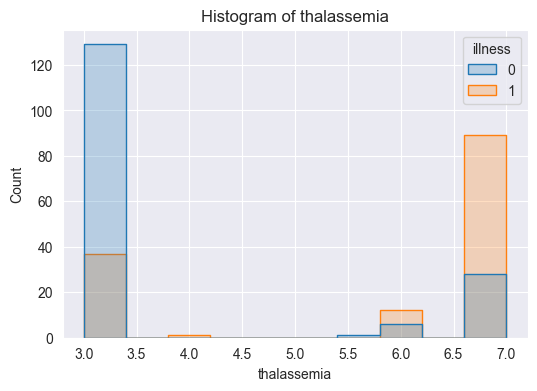

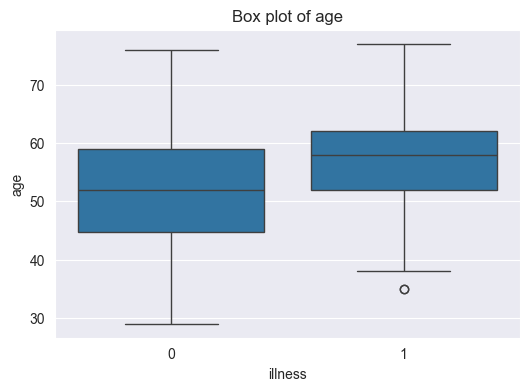

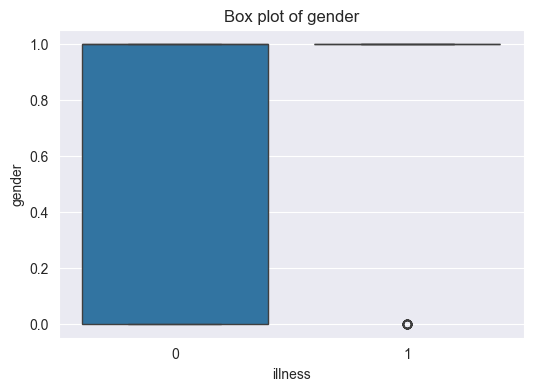

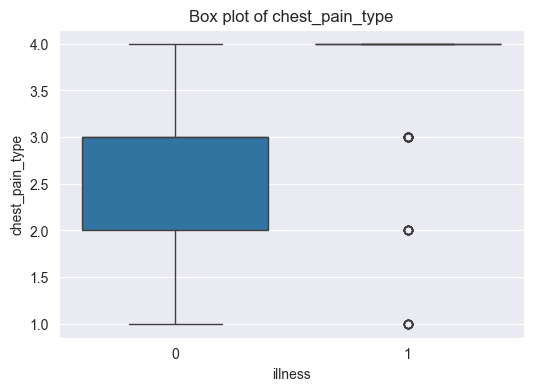

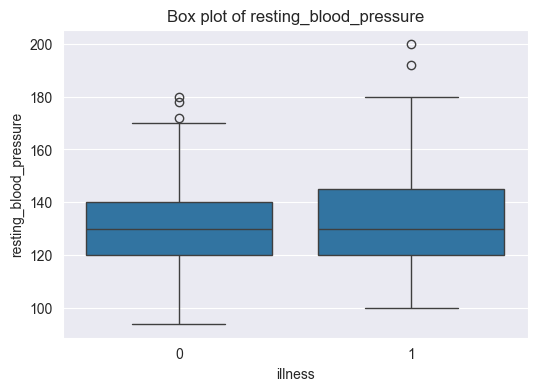

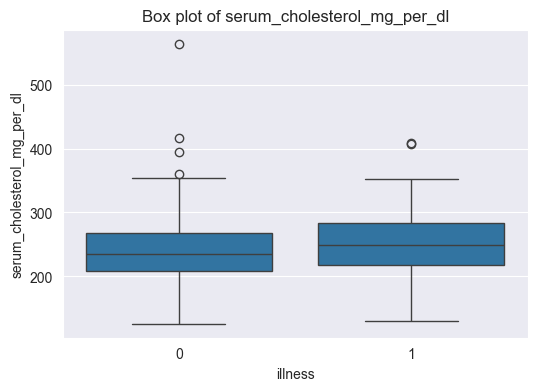

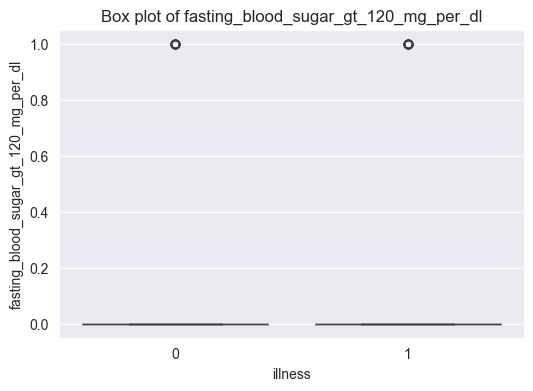

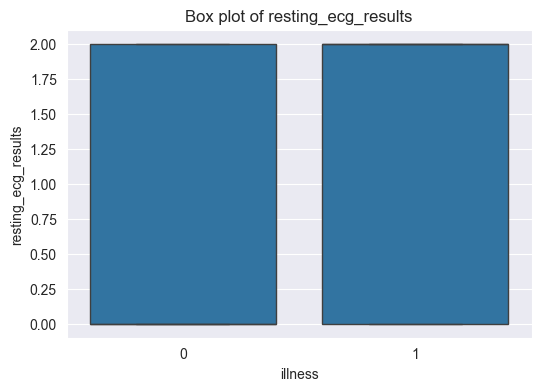

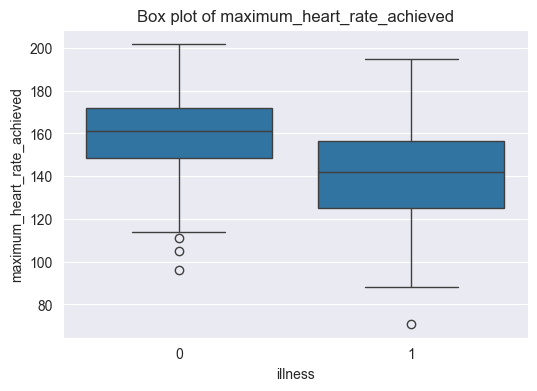

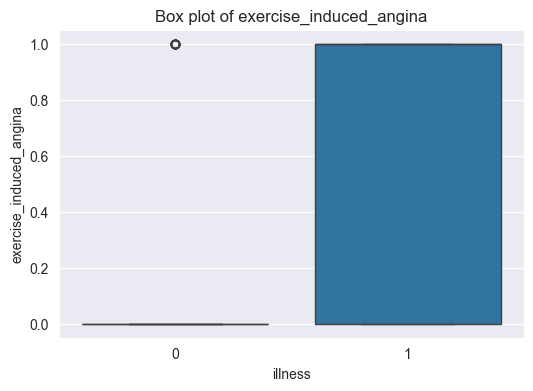

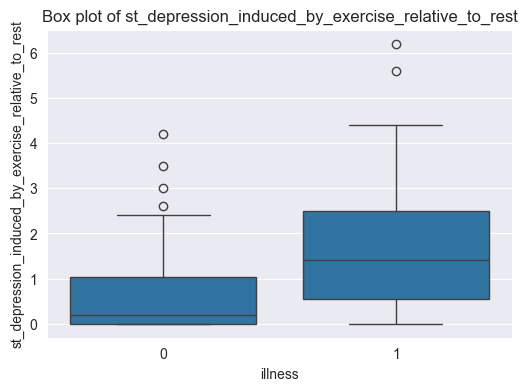

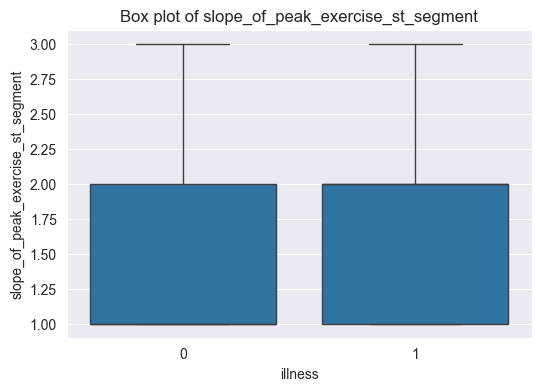

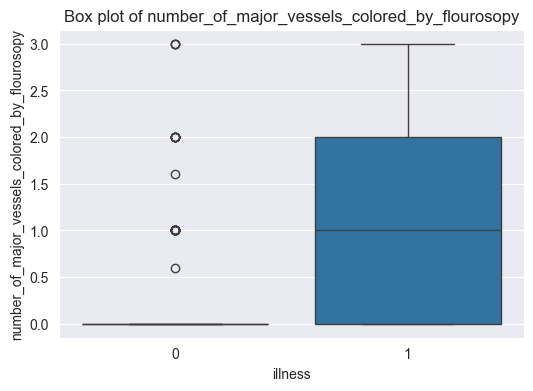

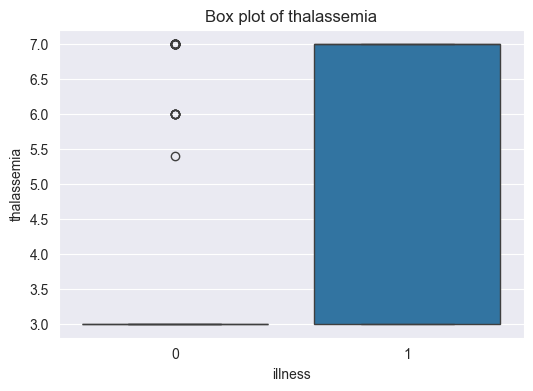

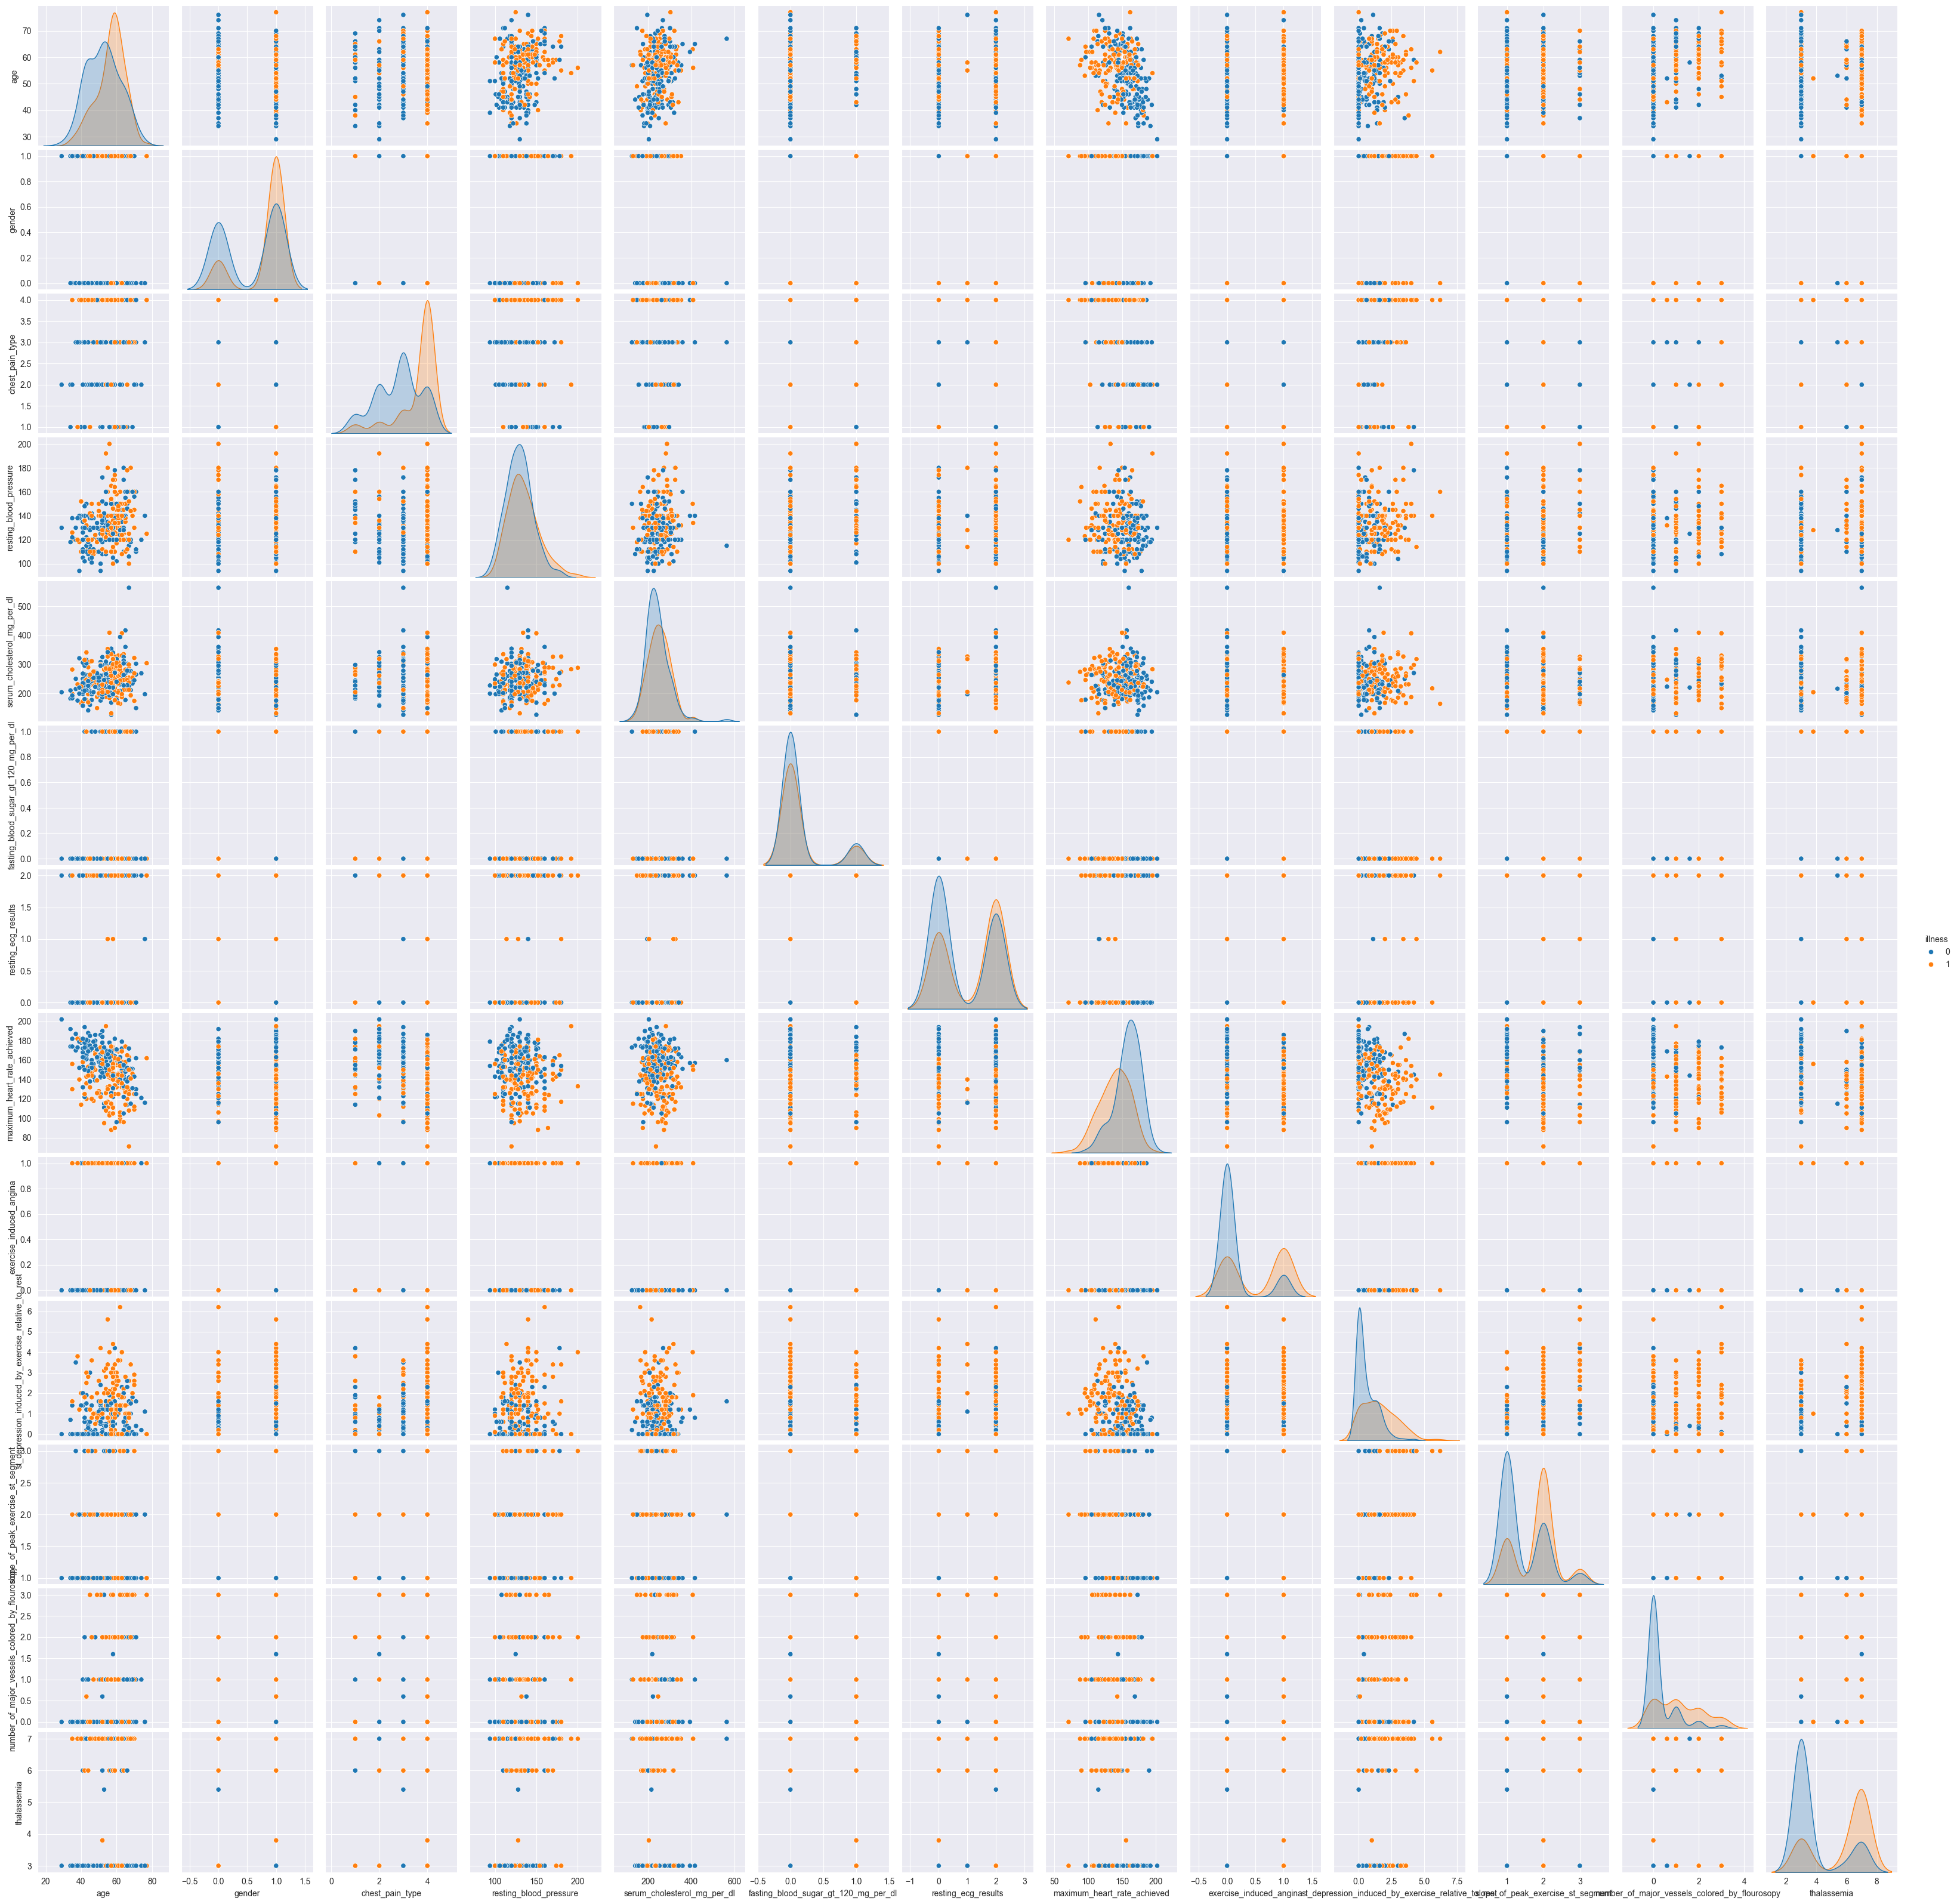

In [13]:
# Concatenate the features and target to form a complete dataset
target_series = pd.Series(target)
complete_data = pd.concat([heart_disease_data_imputed, target_series], axis=1)

# Create a histogram for each feature
for column in heart_disease_data_imputed.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=complete_data, x=column, hue='illness', element='step')
    plt.title(f'Histogram of {column}')
    plt.show()

# Create a box plot for each feature
for column in heart_disease_data_imputed.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='illness', y=column, data=complete_data)
    plt.title(f'Box plot of {column}')
    plt.show()

# Create scatter plots for each pair of features 
sns.pairplot(complete_data, hue='illness')
plt.show()

## Modeling

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(heart_disease_data_preprocessed, target, test_size=0.3, random_state=20)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 27), (91, 27), (212,), (91,))

## Random Forest

For the Random Forest model:
Accuracy on Training data:  100.0
Accuracy on Test data:  81.31868131868131


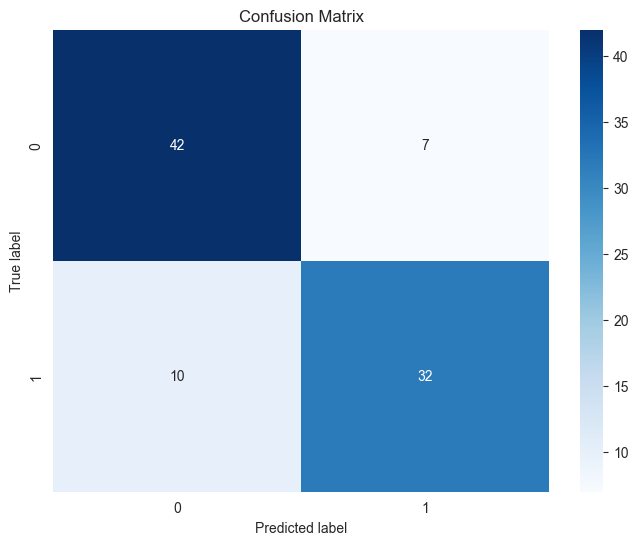

In [16]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    # Add other parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Accuracy on training data
print("For the Random Forest model:")
X_train_prediction_random_forest = best_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_random_forest,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)

# Accuracy on test data
y_pred_random_forest = best_model.predict(X_test)
accuracy = accuracy_score(y_pred_random_forest, y_test)
print(f"Accuracy on Test data: ",accuracy*100)

#Confussion matrix
RF_conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
plt.figure(figsize=(8, 6))
sns.heatmap(RF_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Logistic Regression

Accuracy on Training data:  86.32075471698113
Accuracy on Test data:  83.51648351648352


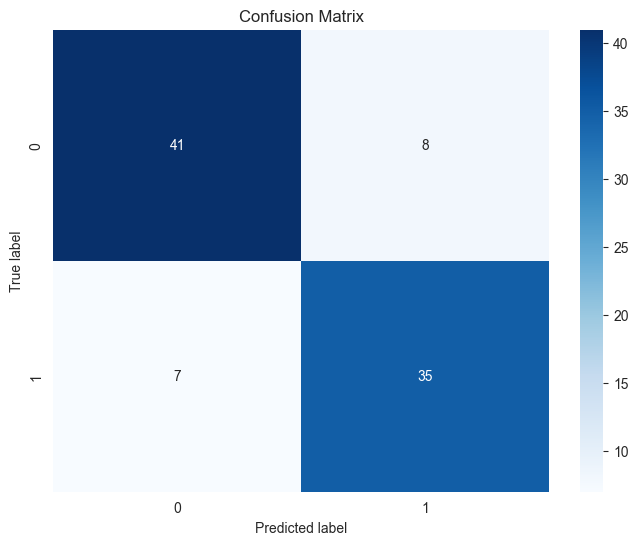

In [17]:
# Initialize the classifier
lr_model = LogisticRegression(solver="liblinear",random_state=2 )

# training the model with training data
lr_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_LR = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_LR,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_LR = lr_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_LR, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
LR_conf_matrix = confusion_matrix(y_test, X_test_prediction_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(LR_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost

C:\Users\alexs\PycharmProjects\PfDa_Project_S7\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Accuracy on Training data:  100.0
Accuracy on Test data:  78.02197802197803


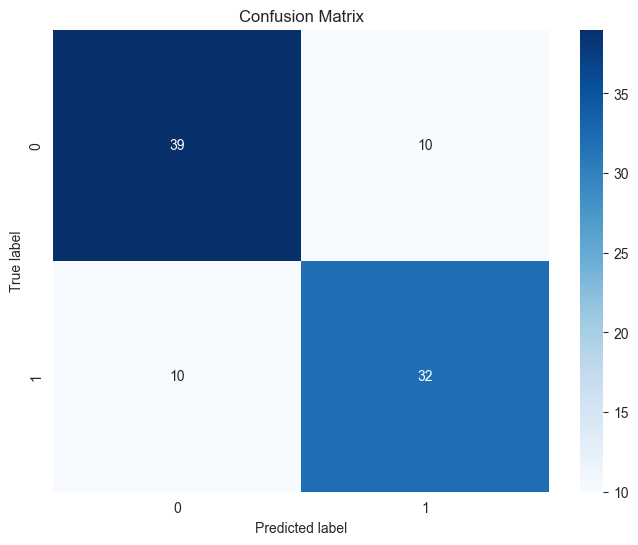

In [18]:
# Initialize the classifier
xgb_model = xgb.XGBClassifier(objective="reg:linear", random_state=42)

# training the model with training data
xgb_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_XGB = xgb_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_XGB,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_XGB = xgb_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_XGB, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
XGB_conf_matrix = confusion_matrix(y_test, X_test_prediction_XGB)
plt.figure(figsize=(8, 6))
sns.heatmap(XGB_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



## Support Vector Classifier

Accuracy on Training data:  91.50943396226415
Accuracy on Test data:  84.61538461538461


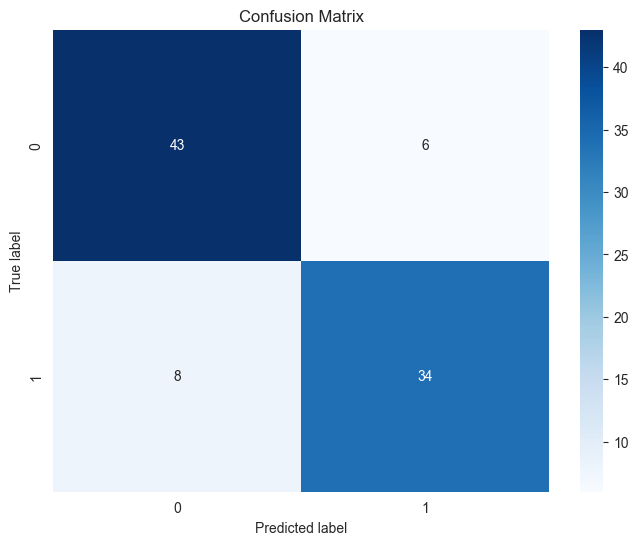

In [19]:
# Initialize the classifier
svc_model = SVC(random_state=20 )

# training the model with training data
svc_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_SVC = svc_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_SVC,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_SVC = svc_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_SVC, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
SVC_conf_matrix = confusion_matrix(y_test, X_test_prediction_SVC)
plt.figure(figsize=(8, 6))
sns.heatmap(SVC_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Neural Network CLassifier

Epoch 1/10
6/6 [==============================] - 2s 36ms/step - loss: 0.6619 - accuracy: 0.6053 - val_loss: 0.6319 - val_accuracy: 0.5909
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.5852 - accuracy: 0.8000 - val_loss: 0.5627 - val_accuracy: 0.6818
Epoch 3/10
6/6 [==============================] - 0s 7ms/step - loss: 0.5205 - accuracy: 0.8316 - val_loss: 0.5121 - val_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 0.4661 - accuracy: 0.8368 - val_loss: 0.4753 - val_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 0.4187 - accuracy: 0.8421 - val_loss: 0.4522 - val_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3824 - accuracy: 0.8421 - val_loss: 0.4391 - val_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 0.3557 - accuracy: 0.8421 - val_loss: 0.4321 - val_accuracy: 0.6818
Epoch 8/10
6/6 [=================

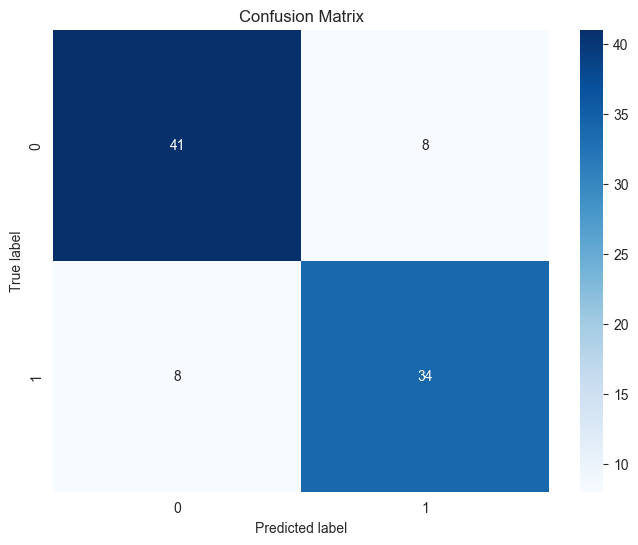

In [20]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 'sigmoid' for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predictions
y_pred_NNC = model.predict(X_test)
y_pred_NNC = np.round(y_pred_NNC).flatten()  # Convert probabilities to binary predictions

# Accuracy
accuracy = accuracy_score(y_test, y_pred_NNC)
print(f"Accuracy on Test data: ",accuracy*100)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_NNC)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Comparisons between models

*Classification Reports*

In [33]:
# Generate classification reports for each model
reports = {
    'Random Forest': classification_report(y_test, y_pred_random_forest, output_dict=True),
    'Logistic Regression': classification_report(y_test, X_test_prediction_LR, output_dict=True),
    'XGBoost': classification_report(y_test, X_test_prediction_XGB, output_dict=True),
    'Support Vector Classifier': classification_report(y_test, X_test_prediction_SVC, output_dict=True),
    'Neural Network Classifier': classification_report(y_test, y_pred_NNC, output_dict=True)
}

In [34]:
# Convert to DataFrame for a tabular view
df_reports = pd.DataFrame(reports).T  # Transpose to get models as rows
df_reports.index.name = 'Model'
df_reports.reset_index(inplace=True)

In [35]:
# Separate DataFrames for each set of columns
df_not_ill = df_reports[['Model', '0']]
df_ill = df_reports[['Model', '1']]
df_accuracy = df_reports[['Model', 'accuracy']]
df_macro_avg = df_reports[['Model', 'macro avg']]
df_weighted_avg = df_reports[['Model', 'weighted avg']]


In [36]:
df_not_ill.head()

,Model,0
0,Random Forest,"{'precision': 0.8076923076923077, 'recall': 0.8571428571428571, 'f1-score': 0.8316831683168318, 'support': 49.0}"
1,Logistic Regression,"{'precision': 0.8541666666666666, 'recall': 0.8367346938775511, 'f1-score': 0.845360824742268, 'support': 49.0}"
2,XGBoost,"{'precision': 0.7959183673469388, 'recall': 0.7959183673469388, 'f1-score': 0.7959183673469388, 'support': 49.0}"
3,Support Vector Classifier,"{'precision': 0.8431372549019608, 'recall': 0.8775510204081632, 'f1-score': 0.86, 'support': 49.0}"
4,Neural Network Classifier,"{'precision': 0.8367346938775511, 'recall': 0.8367346938775511, 'f1-score': 0.8367346938775511, 'support': 49.0}"


In [37]:
df_ill.head()

,Model,1
0,Random Forest,"{'precision': 0.8205128205128205, 'recall': 0.7619047619047619, 'f1-score': 0.7901234567901233, 'support': 42.0}"
1,Logistic Regression,"{'precision': 0.813953488372093, 'recall': 0.8333333333333334, 'f1-score': 0.8235294117647058, 'support': 42.0}"
2,XGBoost,"{'precision': 0.7619047619047619, 'recall': 0.7619047619047619, 'f1-score': 0.7619047619047619, 'support': 42.0}"
3,Support Vector Classifier,"{'precision': 0.85, 'recall': 0.8095238095238095, 'f1-score': 0.8292682926829269, 'support': 42.0}"
4,Neural Network Classifier,"{'precision': 0.8095238095238095, 'recall': 0.8095238095238095, 'f1-score': 0.8095238095238095, 'support': 42.0}"


In [38]:
df_accuracy.head()

,Model,accuracy
0,Random Forest,0.813187
1,Logistic Regression,0.835165
2,XGBoost,0.78022
3,Support Vector Classifier,0.846154
4,Neural Network Classifier,0.824176


In [39]:
df_macro_avg.head()

,Model,macro avg
0,Random Forest,"{'precision': 0.8141025641025641, 'recall': 0.8095238095238095, 'f1-score': 0.8109033125534775, 'support': 91.0}"
1,Logistic Regression,"{'precision': 0.8340600775193798, 'recall': 0.8350340136054422, 'f1-score': 0.8344451182534869, 'support': 91.0}"
2,XGBoost,"{'precision': 0.7789115646258503, 'recall': 0.7789115646258503, 'f1-score': 0.7789115646258503, 'support': 91.0}"
3,Support Vector Classifier,"{'precision': 0.8465686274509804, 'recall': 0.8435374149659864, 'f1-score': 0.8446341463414635, 'support': 91.0}"
4,Neural Network Classifier,"{'precision': 0.8231292517006803, 'recall': 0.8231292517006803, 'f1-score': 0.8231292517006803, 'support': 91.0}"


In [40]:
df_weighted_avg.head()

,Model,weighted avg
0,Random Forest,"{'precision': 0.8136094674556213, 'recall': 0.8131868131868132, 'f1-score': 0.8125017629968124, 'support': 91.0}"
1,Logistic Regression,"{'precision': 0.8356067382230173, 'recall': 0.8351648351648352, 'f1-score': 0.8352847879833932, 'support': 91.0}"
2,XGBoost,"{'precision': 0.7802197802197802, 'recall': 0.7802197802197802, 'f1-score': 0.7802197802197802, 'support': 91.0}"
3,Support Vector Classifier,"{'precision': 0.8463046757164403, 'recall': 0.8461538461538461, 'f1-score': 0.8458161350844278, 'support': 91.0}"
4,Neural Network Classifier,"{'precision': 0.8241758241758241, 'recall': 0.8241758241758241, 'f1-score': 0.8241758241758241, 'support': 91.0}"


*Visual comparison*

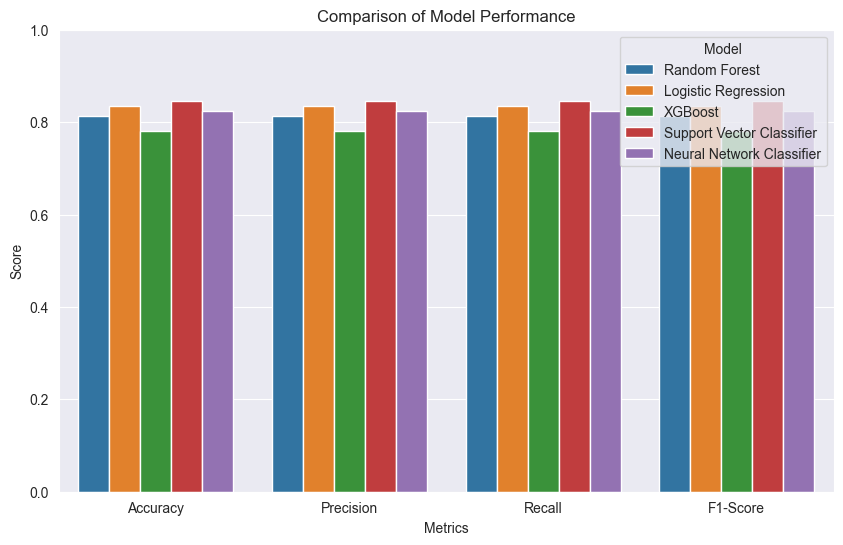

In [24]:
# Extracting metrics
metrics_data = []
for model, report in reports.items():
    metrics_data.append({
        'Model': model,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)
# Melting the DataFrame to make it suitable for sns.barplot
metrics_df_melted = metrics_df.melt('Model', var_name='Metrics', value_name='Values')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrics', y='Values', hue='Model', data=metrics_df_melted)
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming the metrics are between 0 and 1
plt.show()